In [1]:
#This file copied a lot of code from sweep.ipynb, and then adjusted the train and score cells
#as well as the codecell actually running the model for certain settings, for the sole purpose of
#generating output on a per-model-layer basis. This allows us to obtain graphs showing
#the contributions of the individual layers on the output, and gain insight into the functioning
#of successive layers in a DeepESN.

In [2]:
import numpy as np
import random
from DeepESN import DeepESN
from utils import MSE, load_chest, select_indexes
import matplotlib.pyplot as plt
import seaborn as sns
class Struct(object): pass
from sklearn.model_selection import ParameterGrid
import copy
import csv
import time


np.random.seed(7)

In [3]:
def train(Nr, Nl, reg, transient, rhos, lis, iss, con, by_layer = False):
    configs = Struct()
 
    configs.rhos = rhos
    configs.lis = lis
    configs.iss = iss

    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 0 # deactivate pre-train

    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = con 

    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)
    configs.readout.regularizations = 10.0**np.array(range(-16,-1,1))

    deepESN = DeepESN(Nu, Nr, Nl, configs)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)
        
    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)
    
    deepESN.trainReadout(train_states, train_targets, reg)

    return score(deepESN, train_states, test_states, test_targets, by_layer), test_targets[0].tolist()

In [4]:
def score(deepESN, train_states, test_states, test_targets, by_layer = False):
    #compute error SIGNAL FED
    test_states_std = copy.deepcopy(test_states)
    if by_layer:
        test_outputs_std = deepESN.computeOutput(test_states_std, by_layer)
    else: 
        test_outputs_std = deepESN.computeOutput(test_states_std)

    test_error_std = MSE(sum(test_outputs_std), test_targets)

    #compute error SELF FED
    if by_layer:
        test_outputs = [] #In this by_layer case, we store a list of outputs, each of which is a list of outputs per layer
        test_outputs_total = [] # but we still need the totals for computing MSE
        state = [train_states[0][:,-1:]] #set last training state as initial state
        output = [np.array(deepESN.computeOutput(state))] #set last training output as initial output
        for t in range(len(test_states[0][0])):
            # The following code is confusing, but computes outputs per layer,
            # and then stores these in a list called test_outputs
            state = deepESN.computeState(inputs=output, DeepIP=0, initialStates=state[0])
            output_list = deepESN.computeOutput(state, by_layer)
            new_test_output = []
            for layer_output in output_list:
                new_test_output.append(layer_output[0][0])# we store the signals generated by each layer
            test_outputs.append(new_test_output)
            test_outputs_total.append(sum(new_test_output))
            output = [np.array(sum(output_list))] #The sum of this list amounts to the total output

        # MSE relies on the sum of all individual contributions
        test_error = MSE(np.array(sum(test_outputs_total)), np.array(test_targets))
        return test_error, test_outputs, test_error_std, test_outputs_std[:][0].tolist()

    else:
        test_outputs = []
        state = [train_states[0][:,-1:]] #set last training state as initial state
        output = [np.array(deepESN.computeOutput(state))] #set last training output as initial output
        for t in range(len(test_states[0][0])):
            state = deepESN.computeState(inputs=output, DeepIP=0, initialStates=state[0])
            output = deepESN.computeOutput(state)
            test_outputs.append(output[0][0])
            output = [np.array(output)]

        test_error = MSE(np.array(test_outputs), np.array(test_targets))
        return test_error, test_outputs, test_error_std, test_outputs_std[0].tolist()

In [5]:
#construct parameter grid

#set parameter ranges for sweep
parameters = {
    "Nr": [10, 100, 200],          # number of recurrent units
    "Nl": [1, 2, 5, 10],                     # number of recurrent layers
    "reg": [0.01, 0.1, 1.0, 10],                  # regularization of svd
    "transient": [1000],                 # washout
    "rhos": [0.8, 1.0, 1.2, 3.0, 5.0],       # set spectral radius for all recurrent layers
    "lis": [0.1, 0.2, 0.5],            # set leaky rate for all recurrent layers
    "iss": [1.0],               # set input scale for all recurrent layers
    "con": [0.2, 0.5, 1.0],                 # connectivity of recurrent matrix
    ".sampling": [1, 10, 30]             # set step size for sampling, 1 is no sampling. be careful not to make dataset too small
}

data_size = 20000 # pick dataset length to run parameter sweep on

if 640640/max(parameters[".sampling"]) < data_size:
    print("WARNING: highest sampling rate means that resulting dataset is smaller than data_size. \n")

print("Training data length: " + str(int(data_size*0.5)) + "  Validating data length: " + str(int(data_size*0.5)))

search_space = ParameterGrid(parameters)
print("number of models to be swept over: " + str(len(search_space)))
for i in range(10):
    print(search_space[i])
    

Training data length: 10000  Validating data length: 10000
number of models to be swept over: 6480
{'transient': 1000, 'rhos': 0.8, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 3.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 5.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 0.8, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr

In [6]:
#Select desired model for ECG data:
search_space_short = [search_space[1331]]
search_space_short

[{'transient': 1000,
  'rhos': 1.0,
  'reg': 1.0,
  'lis': 0.1,
  'iss': 1.0,
  'con': 0.5,
  'Nr': 100,
  'Nl': 5,
  '.sampling': 1}]

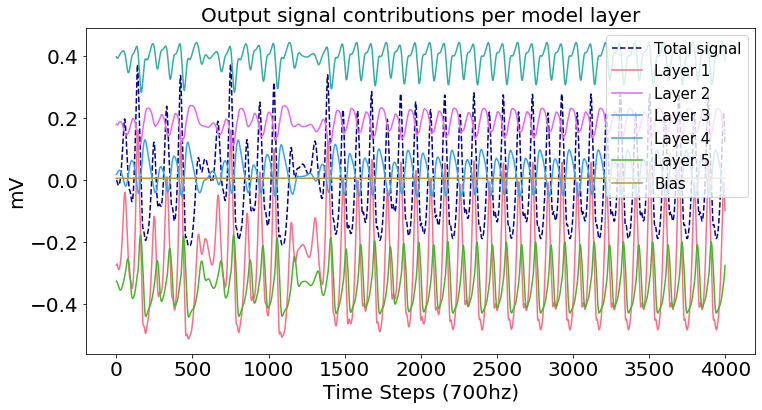

In [42]:
# Plot the datapoints, which may have a strange formatting in the case of by_layer=True
def plot_results(datapoints, by_layer = False, plot_total = False):
    plt.rc('font', size=20) #controls default text size
    plt.rc('axes', titlesize=20) #fontsize of the title
    plt.rc('axes', labelsize=20) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
    plt.rc('legend', fontsize=15) #fontsize of the legend
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.xlabel("Time Steps (700hz)")
    plt.ylabel("mV")
    if by_layer:
        layer_signals = list(map(list, zip(*datapoints))) # Transpose a list of lists
        legend_list = []
        # Plot the total
        if plot_total: 
            plt.plot([sum(i) for i in datapoints], linestyle = '--', color = 'darkblue')
            legend_list.append('Total signal')


        palette = sns.color_palette('husl', len(layer_signals))
        for layer_number, layer_signal in enumerate(layer_signals):
            plt.plot(layer_signal, linestyle='-', color = palette[-layer_number])
            legend_list.append(f'Layer {layer_number + 1}')
        legend_list[-1] = 'Bias'
        
        plt.legend(legend_list, loc = 'upper right')
        plt.title('Output signal contributions per model layer')
        plt.show()
    else:
        plt.plot(datapoints)        
        plt.title('Output signal')
        plt.show()

plot_results(output[1], by_layer_setting, plot_total = True)


input length =  19999
.7 =  13999
.8 =  15999
-1 =  19998
Done loading data


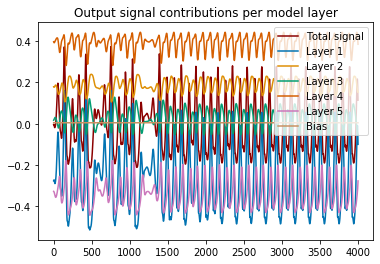

In [8]:

np.random.seed(7)
random.seed(10)


# run the model, obtain results

by_layer_setting = True

dataset, Nu, TR_indexes, VL_indexes, TS_indexes = load_chest('datasets', data_size, 1)

args = search_space_short[0]   #This code looks weird due to a legacy issue. We're just selecting model parameters.

output, test_targets = train(Nr=args['Nr'], Nl=args['Nl'], reg=args['reg'], transient=args['transient'], rhos=args['rhos'], lis=args    ['lis'], iss=args['iss'], con=args['con'], by_layer = by_layer_setting)

#Plot per layer:
plot_results(output[1], by_layer_setting, True)



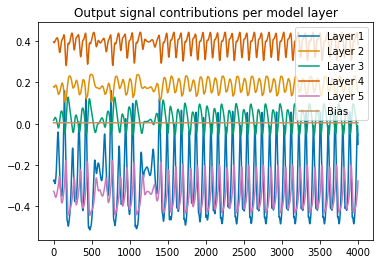

In [9]:
plot_results(output[1], by_layer_setting)